In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt
import torchaudio
from ltng.ae import VoiceAutoEncoder
from IPython.display import Audio
import librosa
from librosa.display import specshow
from pathlib import Path
from itertools import starmap
from copy import deepcopy
import diffsptk
import pysptk

from test_rtf import dict2object, get_instance
from models.utils import AudioTensor, fir_filt

In [3]:
v1_ckpt_path = "for_comparison/ae/vctk/golf-v1/checkpoints/epoch=537-step=993148-val_loss=3.086.ckpt"
ff_ckpt_path = "for_comparison/ae/vctk/golf-frame/checkpoints/epoch=539-step=996840-val_loss=3.073.ckpt"
ss_ckpt_path = (
    "for_comparison/ae/vctk/golf/checkpoints/epoch=539-step=996840-val_loss=3.064.ckpt"
)

v1_cfg_path, ff_cfg_path, ss_cfg_path = [
    Path(ckpt_path).parent.parent / "config.yaml"
    for ckpt_path in [v1_ckpt_path, ff_ckpt_path, ss_ckpt_path]
]

test_file = (
    "/home/ycy/data-disk/Datasets/VCTK-Corpus-0.92-raw/24k-mic1/p360/p360_003_mic1.wav"
)
test_f0 = Path(test_file).with_suffix(".pv")

In [4]:
def load_config(config_path):
    with open(config_path) as f:
        config = yaml.safe_load(f)
    return (
        config["model"]["init_args"]
        if "class_path" in config["model"]
        else config["model"]
    )


def load_model(ckpt_path, config):
    model = VoiceAutoEncoder.load_from_checkpoint(
        ckpt_path, map_location="cpu", strict=True, **dict2object(config)
    ).cpu()
    model.eval()
    return model


v1_cfg, ff_cfg, ss_cfg = map(load_config, [v1_cfg_path, ff_cfg_path, ss_cfg_path])
v1_fs_cfg = deepcopy(v1_cfg)
v1_fs_cfg["decoder"]["init_args"]["harm_filter"][
    "class_path"
] = "models.filters.LTVMinimumPhaseFilterPrecise"
v1_fs_cfg["decoder"]["init_args"]["harm_filter"]["init_args"].pop("window")
v1_fs_cfg["decoder"]["init_args"]["harm_filter"]["init_args"].pop("window_length")
print(v1_cfg)
print(v1_fs_cfg)

v1_model, ff_model, ss_model, v1_fs_model = starmap(
    load_model,
    zip(
        [v1_ckpt_path, ff_ckpt_path, ss_ckpt_path, v1_ckpt_path],
        [v1_cfg, ff_cfg, ss_cfg, v1_fs_cfg],
    ),
)

{'decoder': {'class_path': 'models.hpn.HarmonicPlusNoiseSynth', 'init_args': {'harm_oscillator': {'class_path': 'models.synth.DownsampledIndexedGlottalFlowTable', 'init_args': {'hop_rate': 10, 'in_channels': 64, 'oversampling': 4, 'equal_energy': True, 'table_size': 100, 'table_type': 'derivative', 'normalize_method': 'constant_power', 'align_peak': True, 'trainable': False, 'min_R_d': 0.3, 'max_R_d': 2.7, 'lf_v2': True, 'points': 2048}}, 'noise_generator': {'class_path': 'models.noise.StandardNormalNoise'}, 'harm_filter': {'class_path': 'models.filters.LTVMinimumPhaseFilter', 'init_args': {'window': 'hanning', 'window_length': 960, 'lpc_order': 22, 'lpc_parameterisation': 'rc2lpc', 'max_abs_value': 1.0}}, 'noise_filter': {'class_path': 'models.filters.LTVZeroPhaseFIRFilter', 'init_args': {'window': 'hanning', 'conv_method': 'direct', 'n_mag': 256}}, 'end_filter': {'class_path': 'models.filters.LTIAcousticFilter', 'init_args': {'length': 128, 'conv_method': 'fft'}}}}, 'criterion': {'cl

0.0 129.085151


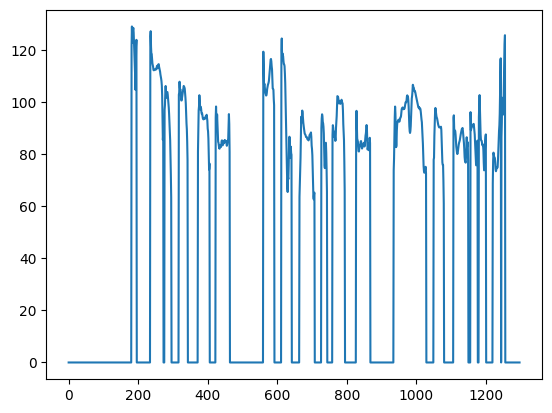

In [5]:
x, sr = torchaudio.load(test_file)
x = x[0]
f0 = np.loadtxt(test_f0)
print(f0.min(), f0.max())

f0_infer = AudioTensor(torch.from_numpy(f0).float().unsqueeze(0), hop_length=120)
x_infer = AudioTensor(x.unsqueeze(0), hop_length=1)
params = {"phase": torch.where(f0_infer > 0, f0_infer, 150) / sr}


@torch.no_grad()
def recon(model):
    return model(x_infer, f0_infer, params)


plt.plot(f0)
plt.show()

Audio(x, rate=sr)

In [6]:
v1_recon, v1_params = recon(v1_model)
ff_recon, ff_params = recon(ff_model)
ss_recon, ss_params = recon(ss_model)
v1_fs_recon, v1_fs_params = recon(v1_fs_model)
print(torch.min(v1_fs_recon), torch.max(v1_fs_recon))
Audio(v1_recon.as_tensor().numpy()[0], rate=sr)

tensor(nan) tensor(nan)


torch.Size([1, 649]) torch.Size([1, 649, 22])


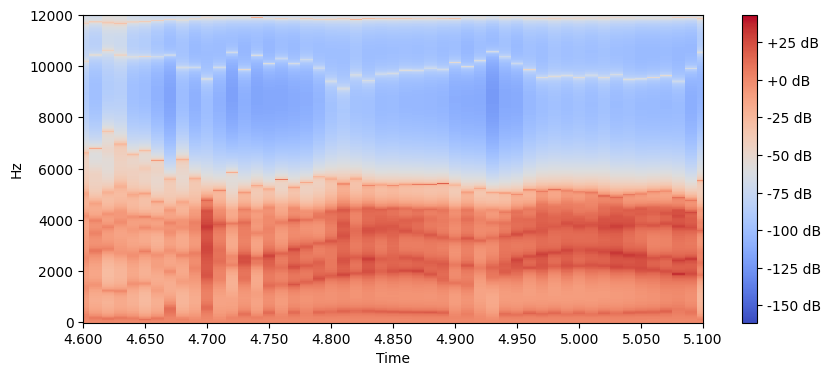

In [136]:
# gain, a = ss_params["end_filter_params"]
gain, a = v1_fs_params["harm_filter_params"]
print(gain.shape, a.shape)


def lpc2spec(g, a):
    g, a = g.as_tensor(), a.as_tensor()
    order = a.shape[-1]
    lpc = torch.cat([g[..., None], a], dim=-1)
    trsfm = nn.Sequential(
        diffsptk.LinearPredictiveCoefficientsToLineSpectralPairs(order, sample_rate=sr),
        diffsptk.LineSpectralPairsToSpectrum(order, 1024, out_format="db"),
    )
    return trsfm(lpc)


# spec_normalise = lambda x: x - 2 * np.log(np.linalg.norm(np.exp(x * 0.5), axis=0, ord=2) + 1e-8)
spec_normalise = lambda x: x - x[0]

spec = lpc2spec(torch.ones_like(gain), a).squeeze().numpy().T
spec = spec_normalise(spec)
# spec -= spec.max()
# spec = (lambda x: x - 2 * np.log(np.linalg.norm(np.exp(x * 0.5), axis=0, ord=2)))(spec)

plt.figure(figsize=(10, 4))
specshow(spec, sr=sr, hop_length=240, x_axis="time", y_axis="linear")
plt.xlim(4.6, 5.1)
plt.colorbar(format="%+2.0f dB")
plt.show()

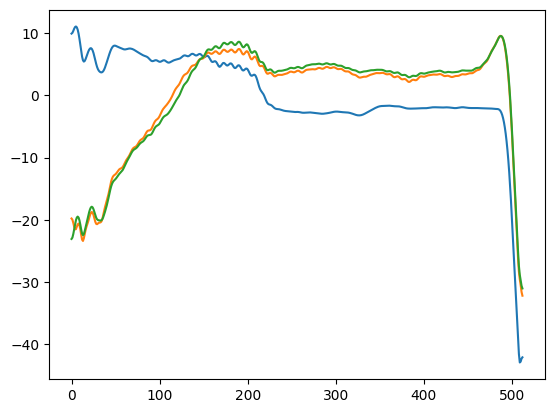

In [151]:
with torch.no_grad():
    v1_iir = v1_model.decoder.end_filter.impulse_response.numpy()
    ff_iir = ff_model.decoder.room_filter.impulse_response.numpy()
    ss_iir = ss_model.decoder.room_filter.impulse_response.numpy()

v1_iir_db = 20 * np.log10(np.abs(np.fft.rfft(v1_iir, 1024)))
ff_iir_db = 20 * np.log10(np.abs(np.fft.rfft(ff_iir, 1024)))
ss_iir_db = 20 * np.log10(np.abs(np.fft.rfft(ss_iir, 1024)))

plt.plot(v1_iir_db)
plt.plot(ff_iir_db)
plt.plot(ss_iir_db)
plt.show()


In [147]:
v1_spec, ff_spec, ss_spec = starmap(
    lambda x, iir: spec_normalise(lpc2spec(*x).squeeze().numpy().T + iir[:, None]),
    zip(
        [
            v1_params["harm_filter_params"],
            ff_params["end_filter_params"],
            ss_params["end_filter_params"],
        ],
        [v1_iir_db, ff_iir_db, ss_iir_db],
    ),
)

In [148]:
sptk_spec = nn.Sequential(
    diffsptk.Frame(1024, 240).double(),
    diffsptk.Window(1024).double(),
    diffsptk.LinearPredictiveCodingAnalysis(22, 1024).double(),
    diffsptk.LinearPredictiveCoefficientsToLineSpectralPairs(22, sample_rate=sr).double(),
    diffsptk.LineSpectralPairsToSpectrum(22, 1024, out_format="db").double(),
)(x_infer.as_tensor().squeeze().double()).numpy().T
print(np.count_nonzero(np.isnan(sptk_spec)))
sptk_spec = spec_normalise(sptk_spec)
print(sptk_spec.shape, ss_spec.shape)

0
(513, 649) (513, 649)


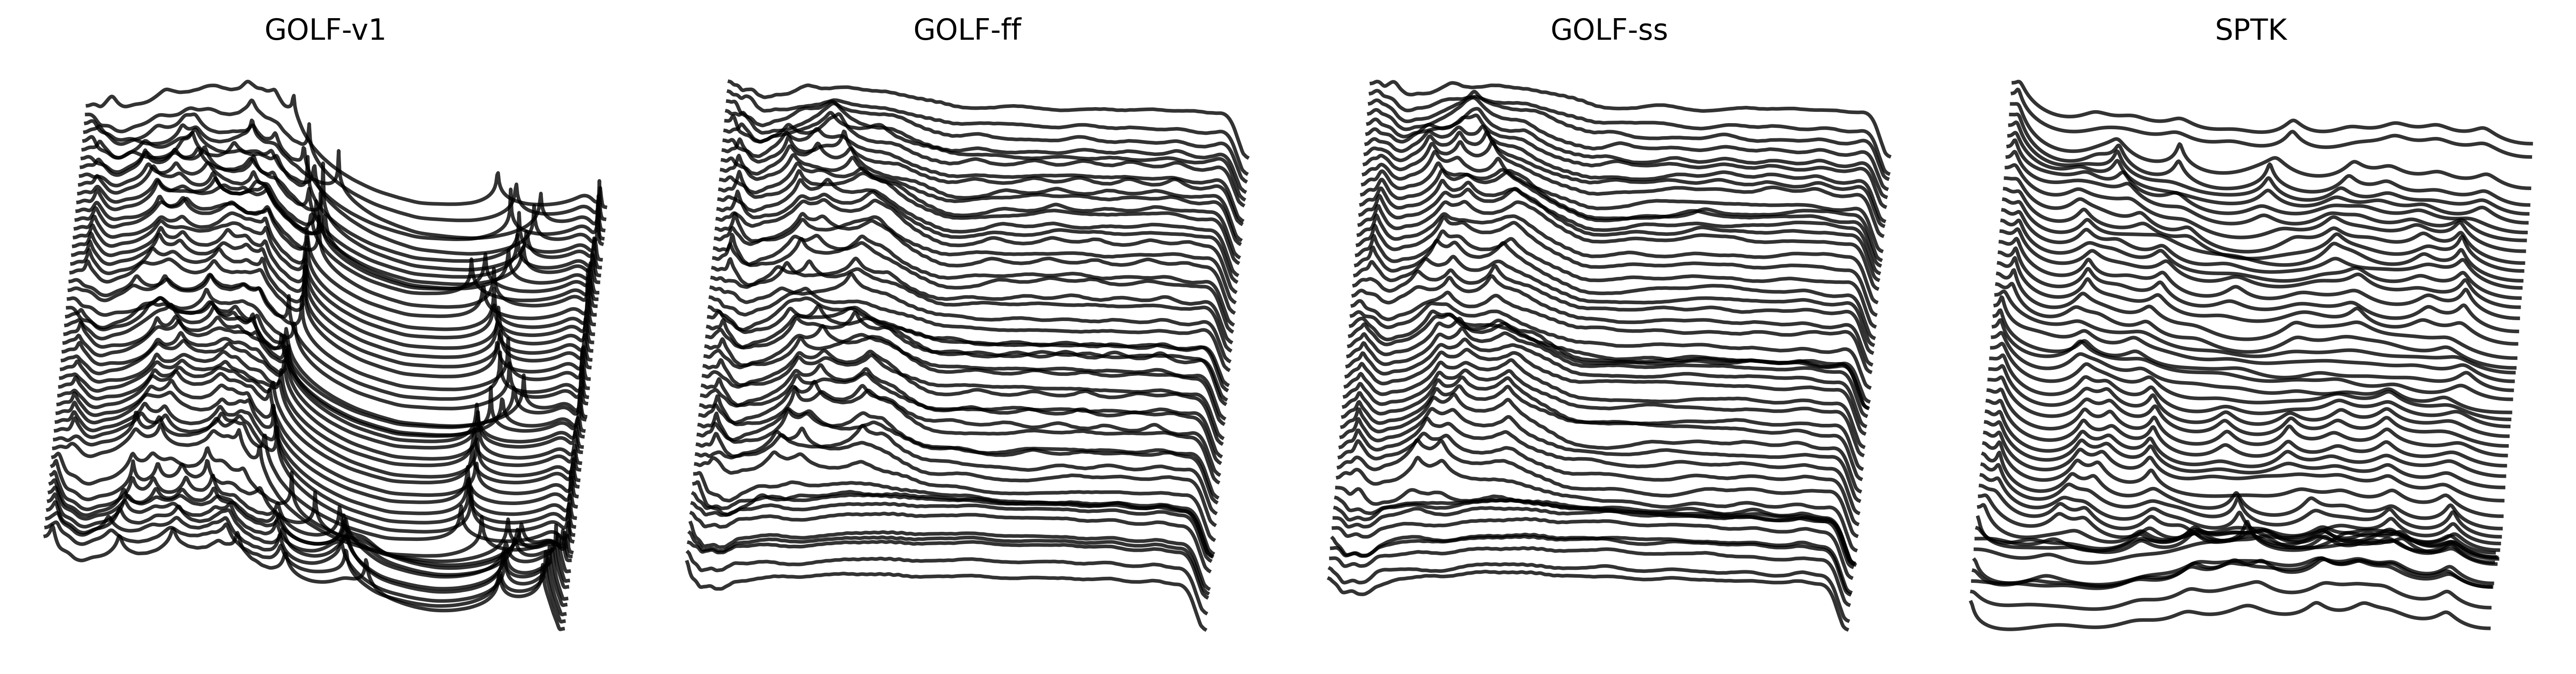

In [149]:
# target_slice = slice(450, 600)
min_t, max_t = 470, 520
# target_spec = spec[:, target_slice]

freqs = np.arange(spec.shape[0]) / 1024 * sr

fig, ax = plt.subplots(1, 4, figsize=(15, 4), layout="tight", dpi=400)
freq_offset = 20
spec_offset = 10
for i in range(max_t - min_t):
    idx = min_t + i
    ax[0].plot(
        freqs - i * freq_offset, v1_spec[:, idx] - i * spec_offset, "k", alpha=0.8
    )
    ax[1].plot(
        freqs - i * freq_offset, ff_spec[:, idx] - i * spec_offset, "k", alpha=0.8
    )
    ax[2].plot(
        freqs - i * freq_offset, ss_spec[:, idx] - i * spec_offset, "k", alpha=0.8
    )
    ax[3].plot(
        freqs - i * freq_offset, sptk_spec[:, idx] - i * spec_offset, "k", alpha=0.8
    )
    # plt.plot(freqs - i * 20, target_spec[:, i] - i * 7, "k", alpha=0.8)
ax[0].set_title("GOLF-v1")
ax[1].set_title("GOLF-ff")
ax[2].set_title("GOLF-ss")
ax[3].set_title("SPTK")

for i in range(4):
    ax[i].axis("off")


plt.show()